### Calculating the heat flux across the Southern Ocean transect 34°S into the Atlantic Ocean (70°W-22°E)

In [1]:
base = '/g/data/e14/mv7494/access-om2/archive/'
save = '/g/data/e14/mv7494/HeatDist_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                                                      
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps     
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.patheffects as PathEffects

from dask.distributed import Client
client = Client(n_workers=4)
client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45059 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:42485 Dashboard: /proxy/45059/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [4]:
%%time
# number of seconds per average year, i.e. very close to 60*60*24*365
average_DT = xr.open_mfdataset(base+'1deg_jra55_iaf_branch2000/'+'output*/ocean/ocean_month.nc').average_DT       
average_DT_full = (int(average_DT.sel(time=slice('1972-01','2017-12')).groupby('time.year').sum(dim='time').mean())/1e9) # number of seconds in a year

for e in range(2):
    if e == 0:
        archive = '1deg_jra55_rdf_branch2000_Control/'
    if e == 1:
        archive = '1deg_jra55_iaf_branch2000/'
    print(archive)
    # open wmass.nc file 
    wmass = xr.open_mfdataset(base + archive + 'output*/ocean/ocean_wmass.nc')
    
    # add together the different diagnostics from the advection, submeso, gm and diffusive mixing schemes
    temp_yflux_on_nrho = wmass.temp_yflux_adv_on_nrho + wmass.temp_yflux_submeso_on_nrho + wmass.temp_yflux_gm_on_nrho + wmass.temp_yflux_ndiffuse_on_nrho

    # select 1972-2017 and only transect at 34°S between South America and Africa (70°W-22°E)
    a = temp_yflux_on_nrho.sum(['neutral']).sel(time=slice('1972-01', '2017-12')) # take sum over the temperature dimensions and select 1972-2017
    a = a.sel(grid_xt_ocean=slice(-70,22)).sel(grid_yu_ocean=slice(-35,-34)).sum(['grid_xt_ocean'])[:,0] # select 34.99°S grid cell
    
    # now this is the total grid cell transport across the transect South America-Africa at 35°S
    if e == 0:
        yflux_clim = a * average_DT_full # multiply by seconds in an average year to get from (W) to (J year$^{-1}$)
    if e == 1:
        yflux_iaf = a * average_DT_full
# Wall time: 1min 17s

1deg_jra55_rdf_branch2000_Control/
1deg_jra55_iaf_branch2000/
CPU times: user 1.55 s, sys: 259 ms, total: 1.81 s
Wall time: 3.98 s


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later


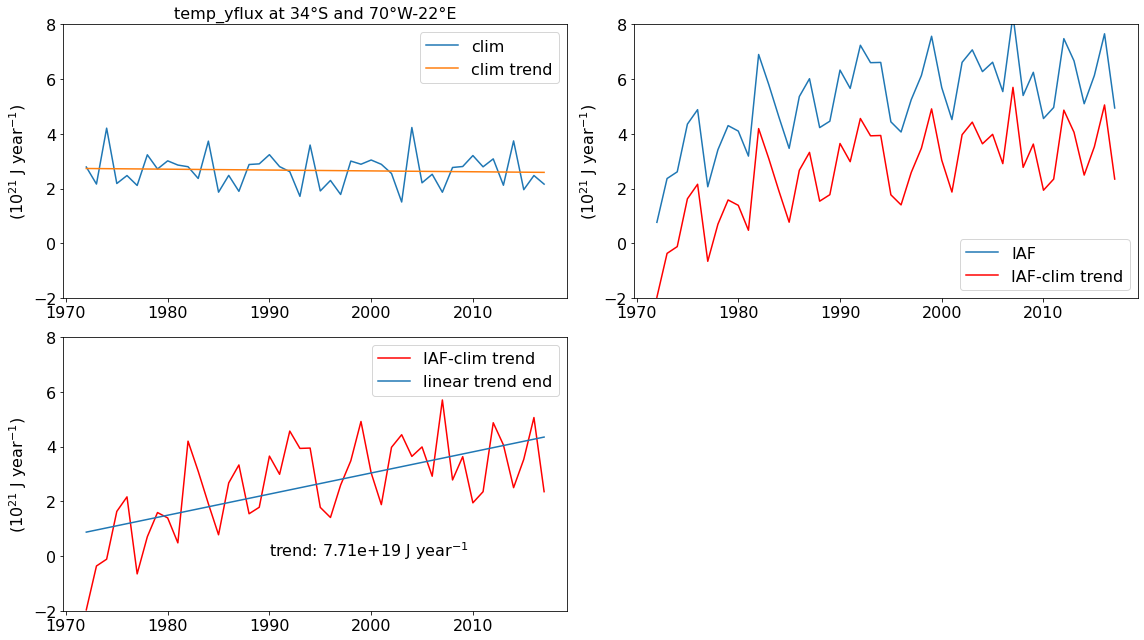

In [5]:
# calculate the linear trend in the control
z1 = np.polyfit(np.linspace(1972,2017,46),yflux_clim, 1) # fit a 1st degree polynomial to the 1962-71 data
p1 = np.poly1d(z1) # construct the polynomial 

t = np.linspace(1972,2017,46) # time dimension array

# preliminary plotting 
fig = plt.figure(figsize=(16, 9),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,2) 
for p in range(4): # loop through four different subplots
    if p == 0:
        ax1 = plt.subplot(gs[0,0]) # first subplot
        
        ax1.plot(t, yflux_clim/1e21, label='clim') # climatological heat flux
        ax1.plot(t, p1(t)/1e21, label='clim trend') # trend of climatological heat flux
        
        plt.ylim(-2,8)
        plt.legend(fontsize=16)
        plt.title('temp_yflux at 34°S and 70°W-22°E', fontsize=16)
        plt.ylabel('($10^{21}$ J year$^{-1}$)', fontsize=16); plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    if p == 1:
        ax1 = plt.subplot(gs[0,1])
        
        ax1.plot(t, yflux_iaf/1e21, label='IAF') # IAF heat flux
        ax1.plot(t, (yflux_iaf-p1(t))/1e21, label='IAF-clim trend', c = 'r') # IAF heat flux when climatological trend removed
        
        plt.ylim(-2,8)
        plt.legend(fontsize=16)
        plt.ylabel('($10^{21}$ J year$^{-1}$)', fontsize=16); plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    if p == 2:
        ax1 = plt.subplot(gs[1,0])
        
        ax1.plot(t, (yflux_iaf-p1(t))/1e21, label='IAF-clim trend', c = 'r') # same data again as in 2nd panel
        z2 = np.polyfit(t,yflux_iaf-p1(t), 1) 
        p2 = np.poly1d(z2) # construct the polynomial 
        plt.plot(t,p2(t)/1e21, label = 'linear trend end') # linear trend of heat flux when climatology removed
        
        plt.ylim(-2,8)
                                                     # average_DT_full = number of seconds in a year, i.e. about 60*60*24*30*365 
            
        plt.text(1990, 0, 'trend: {:.2e}'.format(p2[1]) + ' J year$^{-1}$', fontsize=16)
        plt.legend(fontsize=16)
        plt.ylabel('($10^{21}$ J year$^{-1}$)', fontsize=16); plt.xticks(fontsize=16); plt.yticks(fontsize=16)

# --------------------------------------------------------------------------- #
# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
# --- end of script --------------------------------------------------------- #
plt.savefig(save + 'Calculating_the_heat_transport_fluxes_away_from_the_Southern_Ocean', 
            dpi=300, facecolor='w',
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches='tight', 
            pad_inches=0.1, metadata=None)
# --- end of script --------------------------------------------------------- #
# Wall time: 27 s        